<a href="https://colab.research.google.com/github/Noruzzang/Aiffelthon_qfit/blob/main/test_src/YYY_0115.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pymunk
!pip install ultralytics
!pip show pymunk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 55.3 MB/s eta 0:00:00
Name: pymunk
Version: 6.10.0
Summary: Pymunk is a easy-to-use pythonic 2D physics library
Home-page: https://www.pymunk.org
Author: 
Author-email: Victor Blomqvist <vb@viblo.se>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: cffi
Required-by: 


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 736x1280 1 frame, 1 red ball, 1 table, 1 white ball, 1 yellow ball, 96.1ms
Speed: 21.4ms preprocess, 96.1ms inference, 695.1ms postprocess per image at shape (1, 3, 736, 1280)


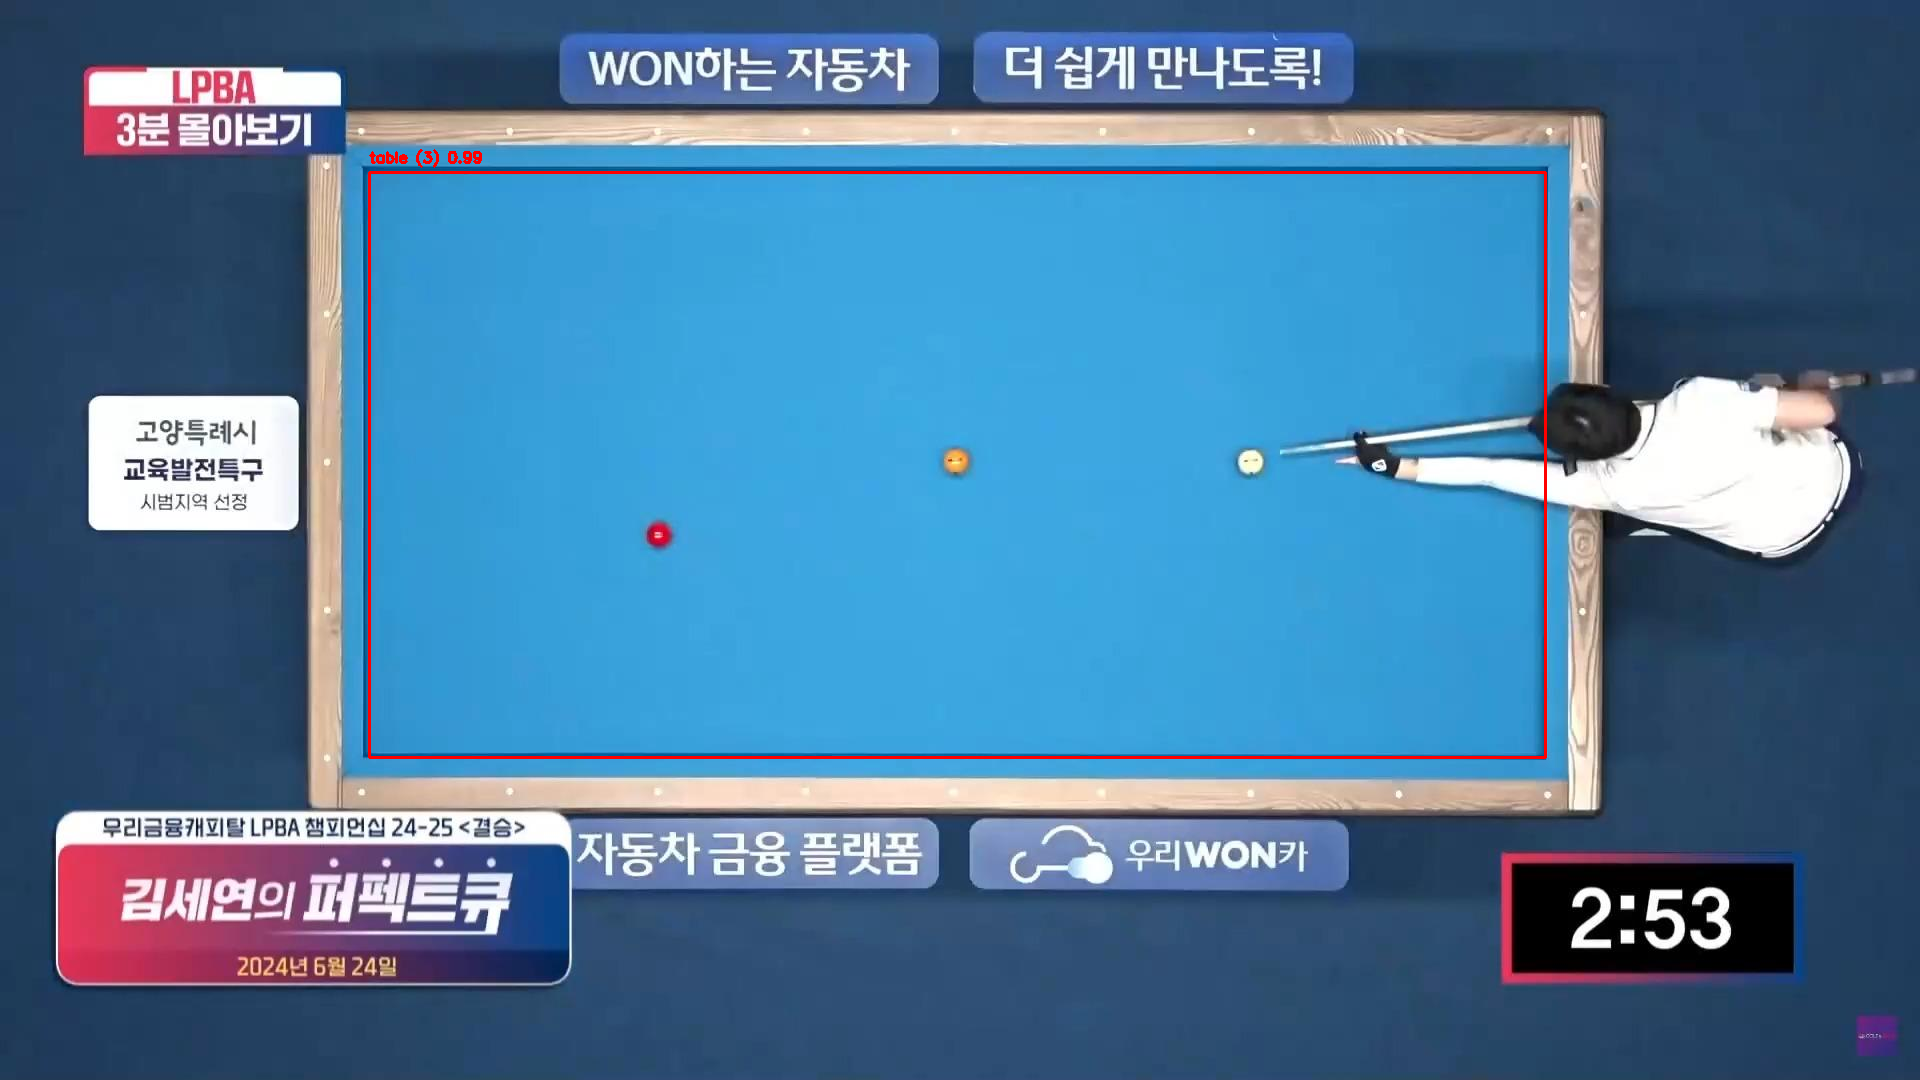

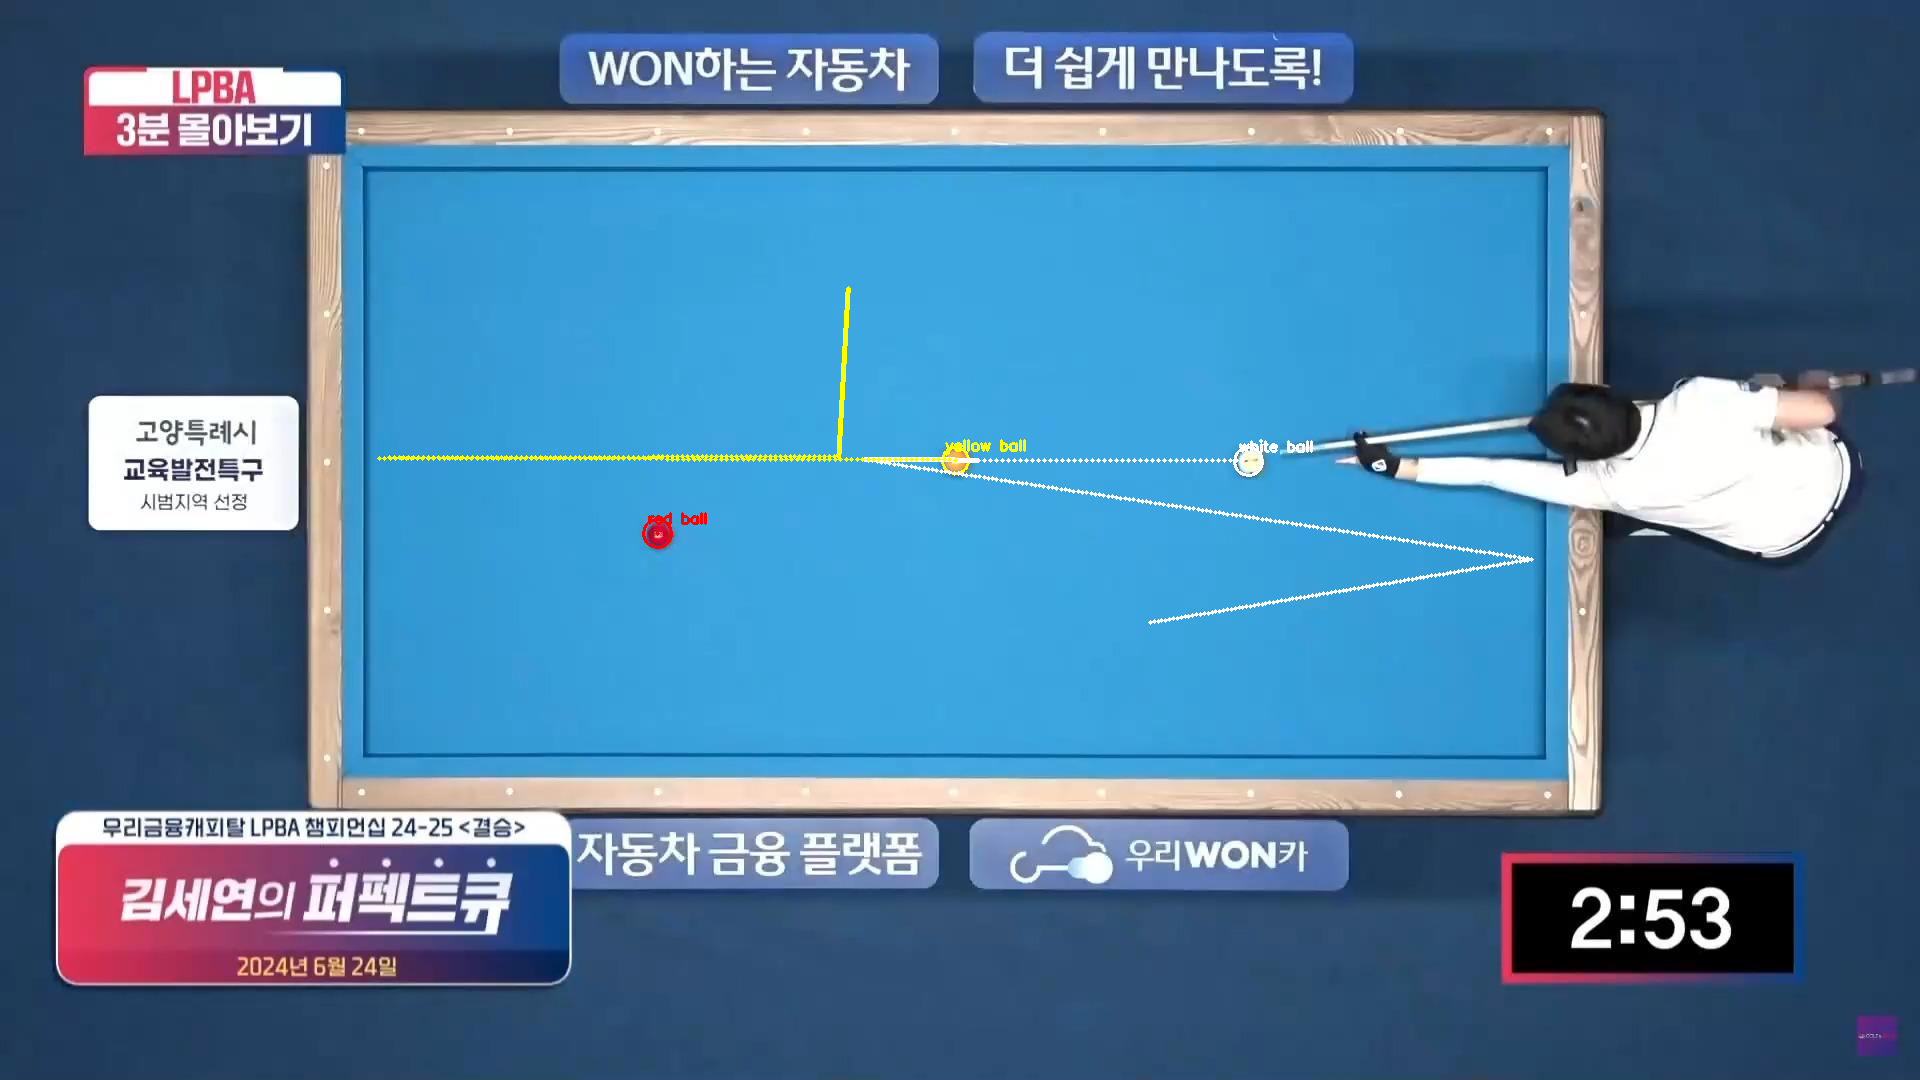

In [3]:
import cv2
from ultralytics import YOLO
import pymunk
from pymunk import Vec2d
from google.colab.patches import cv2_imshow

# YOLO 모델 로드
model = YOLO("JJJ.pt")
image_path = 'MMM.jpg'
image = cv2.imread(image_path)

# 서버에서 공 정보를 기준으로 설정
ball_info = {
    "white ball": None,
    "yellow ball": None,
    "red ball": None
}

# YOLO 모델로 이미지 분석
results = model(image)
class_names = model.names

# 이미지 복사번 생성 (결과 표시용)
output_image = image.copy()

# 테이블 박스 초기화
table_box = None

# YOLO 결과에서 테이블과 공 탐지
for detection in results[0].boxes:
    box = detection.xyxy[0].tolist()
    class_id = int(detection.cls[0])
    confidence = detection.conf[0]
    class_name = class_names[class_id]

    if class_name == "table":
        table_box = box
        cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
        text = f"{class_name} ({class_id}) {confidence:.2f}"
        cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

cv2_imshow(output_image)

# 공 탐지 및 그리기 함수
def detector_org_cuball(image, ball_name):
    color_map = {
        "yellow ball": (0, 255, 255),
        "white ball": (255, 255, 255),
        "red ball": (0, 0, 255)
    }

    for detection in results[0].boxes:
        box = detection.xyxy[0].tolist()
        class_id = int(detection.cls[0])
        class_name = class_names[class_id]

        if class_name == ball_name:
            x = int((box[0] + box[2]) // 2)
            y = int((box[1] + box[3]) // 2)
            radius = int((box[2] - box[0]) // 2)

            if ball_name in color_map:
                cv2.circle(image, (x, y), radius, color_map[ball_name], 2)
                cv2.putText(image, f"{ball_name}", (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, color_map[ball_name], 2)

            return (x, y), radius

    return None, None

# Pymunk 무리 엔지닝 초기화
def setup_physics(space, table_box):
    space.gravity = (0, 0)
    t_x1, t_y1, t_x2, t_y2 = map(int, table_box)

    static_lines = [
        pymunk.Segment(space.static_body, (t_x1, t_y1), (t_x2, t_y1), 1),
        pymunk.Segment(space.static_body, (t_x1, t_y1), (t_x1, t_y2), 1),
        pymunk.Segment(space.static_body, (t_x2, t_y1), (t_x2, t_y2), 1),
        pymunk.Segment(space.static_body, (t_x1, t_y2), (t_x2, t_y2), 1),
    ]

    for line in static_lines:
        line.elasticity = 1.0
        space.add(line)

# Pymunk 공간 생성
space = pymunk.Space()
if table_box:
    setup_physics(space, table_box)

# 공 탐지 및 위치 저장
for ball_name in ball_info.keys():
    ball_info[ball_name] = detector_org_cuball(image, ball_name)

# 공 시무레이션 설정 및 경로 계산
balls = []
if all(ball_info.values()):
    for ball_name, (start_pos, radius) in ball_info.items():
        ball_body = pymunk.Body(mass=1, moment=10)
        ball_body.position = Vec2d(*start_pos)
        ball = pymunk.Circle(ball_body, radius)
        ball.elasticity = 0.9
        ball.friction = 0.05
        space.add(ball_body, ball)
        balls.append((ball_body, ball))

    # 수구 초기 속도 설정
    white_ball_body = balls[0][0]
    target_pos = Vec2d(*ball_info["yellow ball"][0])
    white_ball_body.velocity = (target_pos - white_ball_body.position).normalized() * 600

    # 시무레이션 및 경로 저장
    trajectories = {"white": [], "yellow": [], "red": []}

    for _ in range(500):
        space.step(0.01)
        trajectories["white"].append((int(white_ball_body.position.x), int(white_ball_body.position.y)))
        trajectories["yellow"].append((int(balls[1][0].position.x), int(balls[1][0].position.y)))
        trajectories["red"].append((int(balls[2][0].position.x), int(balls[2][0].position.y)))

    # 경로 표시
    colors = {"white": (255, 255, 255), "yellow": (0, 255, 255), "red": (0, 0, 255)}
    for ball_name, points in trajectories.items():
        for point in points:
            cv2.circle(image, point, 2, colors[ball_name], -1)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
